In [ ]:
%matplotlib inline

# Demonstration of how to fit halo MAHs with the `diffmah` model

## Load a block of target data

These data can be downloaded from the site hosting the project data. But in principle the fitting function should work main progenitors from any sim.

In [71]:
from load_mah_data import load_tng_data
_ret = load_tng_data(data_drn="/Users/aphearin/work/DATA/diffmah_data")
halo_ids, log_mahs, tmpeaks, t_tng, log_mah_fit_min = _ret

## Pick a particular example halo history to fit

In [72]:
from diffmah.fit_mah_helpers import get_loss_data_variable_mp_x0
from diffmah.fit_mah_helpers import mse_loss_variable_mp_x0
from diffmah.utils import jax_adam_wrapper

itest = 0
log_mah_sim = log_mahs[itest, :]
tmpeak_sim = tmpeaks[itest]

p_init, loss_data = get_loss_data_variable_mp_x0(t_tng, log_mah_sim, tmpeak_sim, log_mah_fit_min)

## Use Adam to fit the MAH with the smooth model

In [73]:
n_step = 300
_res = jax_adam_wrapper(mse_loss_variable_mp_x0, p_init, loss_data, n_step, n_warmup=2)
p_best, loss, loss_arr, params_arr, fit_terminates = _res

## Inspect the loss curve to see if we're converged 

(or if fewer steps can be taken for faster fitting)

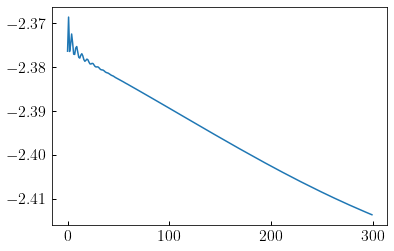

In [74]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_arr))

## Grab the unbounded values of the best-fit parameters

In [75]:
logmp_fit, u_x0, u_early, u_dy = p_best
logt_target, log_mah_target, logtmp, u_k = loss_data

## Transform the unbounded parameters to the actual `diffmah` parameters

In [76]:
from diffmah.individual_halo_assembly import _get_params_from_u_params
x0, k, early, late = _get_params_from_u_params(u_x0, u_k, u_early, u_dy)

## Calculate the MAH using the best-fit model

In [77]:
from diffmah.individual_halo_assembly import _calc_halo_history

logt_fit = np.linspace(0, 1.15, 500)
dmhdt_fit, log_mah_fit = _calc_halo_history(logt_fit, np.log10(tmpeaks[itest]), logmp_fit, x0, k, early, late)

## Compare the model to the simulated MAH

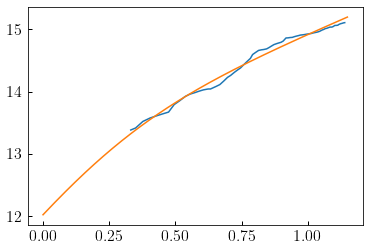

In [78]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logt_target, log_mah_target)
__=ax.plot(logt_fit, log_mah_fit)

## Predicting histories for a collection of halos

After running the fitter, you'll have a large block of MAH parameters for which you'll want to make history predictions. There's a separate kernel that handles this use case that should be a lot more efficient than repeatedly calling the single-halo kernel inside a long python loop. To demonstrate how this works, we'll just generate a bunch of random `diffmah` parameters within the expected bounds.

In [79]:
from diffmah.individual_halo_assembly import _MAH_PARS, _MAH_BOUNDS

n_halos = int(1e4)
TODAY = 13.8
tmpeak_arr = np.zeros(n_halos) + TODAY
logmp_arr = np.zeros(n_halos) + 12.0
mah_x0_arr = np.random.uniform(*_MAH_BOUNDS['mah_x0'], n_halos)
mah_k_arr = np.zeros(n_halos) + _MAH_PARS['mah_k']
mah_early_arr = np.random.uniform(*_MAH_BOUNDS['mah_early'], n_halos)


Since the bounds on the late index depend on the early index, for this last parameter we'll generate a bunch of random values for the unbounded version instead and then call the bounding function to transform.

In [80]:
from diffmah.individual_halo_assembly import _get_late_index

mah_u_dy_arr = np.random.normal(loc=0, scale=1, size=n_halos)
late_index_arr = _get_late_index(mah_u_dy_arr, mah_early_arr)

In [81]:
from diffmah.individual_halo_assembly import _calc_halo_history_vmap

n_times = 200
lgtarr = np.linspace(0, np.log10(TODAY), n_times)
lgtmp_arr = np.log10(tmpeak_arr)
dmhdt_arr, log_mah_arr = _calc_halo_history_vmap(
    lgtarr, lgtmp_arr, logmp_arr, mah_x0_arr, mah_k_arr, mah_early_arr, late_index_arr)

print(dmhdt_arr.shape)
print(log_mah_arr.shape)

(10000, 200)
(10000, 200)


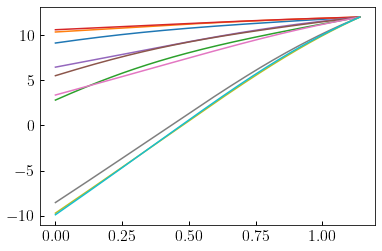

In [82]:
fig, ax = plt.subplots(1, 1)

iplots = np.random.randint(0, n_halos, 10)
for iran in iplots:
    __=ax.plot(lgtarr, log_mah_arr[iran, :])